In [59]:
import json, random, pandas as pd, numpy as np, keras.backend as K
from math import exp, log, fabs
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
%matplotlib inline

import gensim.downloader as api
_word2vec = api.load("glove-wiki-gigaword-50")

In [335]:
%matplotlib notebook

In [116]:
import os, datetime

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

In [61]:
def word2vec(word):
    if word in _word2vec:
        return _word2vec[word]
    return None


def words2vec(words):
    word2embedding = {}
    for word in words:
        if word in _word2vec:
            word2embedding[word] = _word2vec[word]
    return word2embedding

In [62]:
def psd_mahalanobis(wordvec, wordsvec):
    cov = np.cov(wordsvec.T)
    mahalanobis_dist = np.sqrt(wordvec.T @ np.linalg.inv(cov) @ wordvec)
    return mahalanobis_dist

def psd_inf(wordvec, wordsvec):
    return 1 - max(cosine_similarity(wordsvec, [wordvec])[0])

def psd_average(wordvec, wordsvec):
    return 1 - cosine_similarity(wordsvec, [wordvec])[0].mean()

In [63]:
def psd_custom(wordvec, wordsvec):
    def similarity(words, word):
        sim = cosine_similarity(words, [word])
        return sim[:, 0]
    sim = np.zeros(5)
    for _sim in similarity(wordsvec, wordvec):
        min_ind = np.argmax(sim)
        if sim[min_ind] > _sim:
            sim[min_ind] = 1 - _sim
    return sim.mean()

In [64]:
def psd_neural_metric(wordvec, wordsvec):
    return 1 - material_classifiermodel.predict(np.array([wordvec]))[0, 0]

In [1]:
def research_metric(base_words, investigated_words, metric, params={'left': 0, 'right': 40, 'step': 0.5}):
    def count_dist(base_words, investigated_words, metric):
        dists = []
        base_words_vec = np.array(list(words2vec(base_words).values()))
        for word in investigated_words:
            word_vec = word2vec(word)
            if word_vec is None:
                continue
            dist = metric(word_vec, base_words_vec)
            dists.append(dist)
        return dists
    thematic_dists = count_dist(thematic_words_train, thematic_words_test, metric)
    thematic_dists_df = pd.DataFrame(data=thematic_dists, columns=['thematic'])
    casual_dists = count_dist(thematic_words_train, casual_words , metric)
    casual_dists_df = pd.DataFrame(data=casual_dists, columns=['casual'])
    plt.figure()
    ax1 = plt.subplot2grid((1, 1), (0, 0))
    casual_dists_df.plot(kind='kde', ax=ax1)
    thematic_dists_df.plot(kind='kde', ax=ax1)
    plt.legend()
    plt.title(metric.__name__)
    ax1.figure.set_size_inches(10, 10)
    
    true_pred = np.array(thematic_dists)
    false_pred = np.array(casual_dists)
    thresholds = np.arange(params['left'], params['right'], params['step'])
    precisions = []
    recalls = []

    threshold = 1
    for threshold in thresholds:
        TP = true_pred[true_pred < threshold]
        FN = true_pred[true_pred > threshold]
        FP = false_pred[false_pred < threshold]
        TN = false_pred[false_pred > threshold]
        if len(TP) + len(FP) == 0:
            precision = 1
        else:
            precision = len(TP) / (len(TP) + len(FP) + 0.0001)
        recall = len(TP) / (len(TP) + len(FN) + 0.0001)

        precisions.append(precision)
        recalls.append(recall)
    
    plt.figure()
    plt.plot(thresholds, precisions, label='precision')
    plt.plot(thresholds, recalls, label='recall')
    plt.xlabel('threshold')
    plt.ylabel('%')
    plt.legend()
    
    return precisions, recalls, thresholds

In [65]:
import json
from pprint import pprint

with open('material.json') as f:
    thematic_words = json.load(f)['thematic_words']
random.shuffle(thematic_words)    
train_size = int(len(thematic_words) * 0.4)
thematic_words_train = thematic_words[:train_size]
thematic_words_test = thematic_words[train_size:]

with open('casual.json') as f:
    casual_words = json.load(f)['casual']
len(thematic_words)

275

In [ ]:
# neural_ps, neural_rs, th = research_metric(thematic_words, thematic_words, psd_neural_metric,  params={'left': 0, 'right': 1, 'step': 0.005})
# _, _, _ = research_metric(thematic_words_train, thematic_words_test, psd_mahalanobis)
# inf_ps, inf_rs, inf_th = research_metric(thematic_words_train, thematic_words_test, psd_inf, params={'left': 0.3, 'right': 1.25, 'step': 0.005})
# average_ps, average_rs, average_th = research_metric(thematic_words_train, thematic_words_test, psd_average, params={'left': 0.2, 'right': 1.5, 'step': 0.005})
# custom_ps, custom_rs, custom_th = research_metric(thematic_words_train, thematic_words_test, psd_custom, params={'left': 0, 'right': 0.2, 'step': 0.001})

In [308]:
def count_dist(base_words, investigated_words, metric):
    dists = []
    data = {
        'word': [],
        'thematic': []
    }
    base_words_vec = np.array(list(words2vec(base_words).values()))
    for word in investigated_words:
        word_vec = word2vec(word)
        if word_vec is None:
            continue
        dist = metric(word_vec, base_words_vec)
        dists.append(dist)
        data['word'].append(word)
        data['thematic'].append(dist)
    return dists, data
thematic_dists, data = count_dist(thematic_words_train, thematic_words_test, psd_custom)
thematic_dists_df = pd.DataFrame(data=data, columns=['word', 'thematic'])

In [309]:
casual_dists, data = count_dist(thematic_words_train, casual_words , psd_custom)
casual_dists_df = pd.DataFrame(data=data)

In [310]:
thematic_dists_df.sort_values(by='thematic', ascending=False).head(40)

,word,thematic
17,silver,0.189218
29,clay,0.187872
48,francium,0.170061
13,hydroxyethyl,0.169053
37,einsteinium,0.168065
35,meitnerium,0.156137
9,allantoin,0.152206
56,phenyl,0.149446
49,copolymer,0.147346
61,polyacrylamide,0.147263


In [378]:
l_custom_th = (custom_th - custom_th.min()) / (custom_th.max() - custom_th.min())
l_average_th = (average_th - average_th.min()) / (average_th.max() - average_th.min())
l_inf_th = (inf_th - inf_th.min()) / (inf_th.max() - inf_th.min())

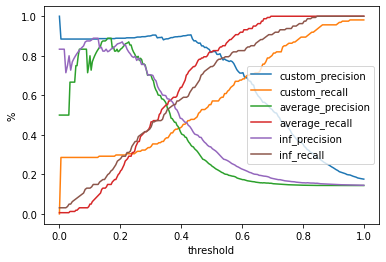

In [379]:
plt.figure()
plt.plot(l_custom_th, custom_ps, label='custom_precision')
plt.plot(l_custom_th, custom_rs, label='custom_recall')
plt.plot(l_average_th, average_ps, label='average_precision')
plt.plot(l_average_th, average_rs, label='average_recall')
plt.plot(l_inf_th, inf_ps, label='inf_precision')
plt.plot(l_inf_th, inf_rs, label='inf_recall')
plt.xlabel('threshold')
plt.ylabel('%')
plt.legend()

In [ ]:
for precision, recall, threshold in zip(inf_ps, inf_rs, inf_th):
    print(f"p={precision} r={recall} th={threshold}")

In [286]:
for precision, recall, threshold in zip(custom_ps, custom_rs, custom_th):
    print(f"p={precision} r={recall} th={threshold}")

In [287]:
for precision, recall, threshold in zip(average_ps, average_rs, average_th):
    print(f"p={precision} r={recall} th={threshold}")

p=0.999980000399992 r=0.05952373866221588 th=0.2
p=0.999980000399992 r=0.05952373866221588 th=0.21000000000000002
p=0.9999833336111065 r=0.07142848639465905 th=0.22000000000000003
p=0.9999833336111065 r=0.07142848639465905 th=0.23000000000000004
p=0.9999833336111065 r=0.07142848639465905 th=0.24000000000000005
p=0.999985714489793 r=0.08333323412710222 th=0.25000000000000006
p=0.999985714489793 r=0.08333323412710222 th=0.26000000000000006
p=0.9999888890123443 r=0.10714272959198858 th=0.2700000000000001
p=0.999990000099999 r=0.11904747732443176 th=0.2800000000000001
p=0.999990909173553 r=0.13095222505687493 th=0.2900000000000001
p=0.9999928571938772 r=0.16666646825420445 th=0.3000000000000001
p=0.9999941176816607 r=0.20238071145153397 th=0.3100000000000001
p=0.999994736869806 r=0.22619020691642033 th=0.3200000000000001
p=0.9999950000249999 r=0.23809495464886352 th=0.3300000000000001
p=0.9999952381179137 r=0.24999970238130667 th=0.34000000000000014
p=0.9999952381179137 r=0.249999702381306

### Обучение метрики

Попытаемся получить лучшую метрику с помощью нейронной сети

Решаем задачу классификации слов на те, что относятся к материалам и те что не относятся

Проблема: размер датасета слов

In [7]:
import numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers

In [9]:
len(thematic_words)

272

In [319]:
data = []
labels = []
for thematic_word in thematic_words:
    if thematic_word in _word2vec:
        data.append(word2vec(thematic_word))
        labels.append(np.array(1))
    
for casual_word in casual_words:
    if casual_word in _word2vec:
        data.append(word2vec(casual_word))
        labels.append(np.array(0))

c = list(zip(data, labels))
random.shuffle(c)

data, labels = zip(*c)

    
data = np.array(data)
labels = np.array(labels)

In [320]:
labels.shape

(1227,)

In [321]:
data.shape

(1227, 50)

In [322]:
train_size = int(len(data) * 0.7)
validation_size = int(len(data) * 0.2)
test_size = len(data) - train_size - validation_size

data_train         = data[:train_size]
labels_train       = labels[:train_size]
data_validation    = data[train_size:train_size+validation_size]
labels_validation  = labels[train_size:train_size+validation_size]
data_test          = data[train_size+validation_size:]
labels_test        = labels[train_size+validation_size:]

In [323]:
data_dim = 50
significantly_dim = 10
drop_out = 0.2
output_dim = 1

input_layer = layers.Input(shape=(data_dim,))
significantly_layer = layers.Dense(significantly_dim, activation='relu')(input_layer)
significantly_layer_dropout = layers.Dropout(drop_out)(significantly_layer)
output_layer = layers.Dense(output_dim, activation=tf.keras.activations.sigmoid)(significantly_layer_dropout)

material_classifier = Model(input_layer, output_layer)
material_significantly_coords = Model(input_layer, d)

material_classifier.summary()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_15 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [324]:
def custom_metric(true, pred):
    return K.abs(K.round(true) - K.round(pred))
custom_metric.__name__ = 'round_error'

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [325]:
optimizer = keras.optimizers.Adam()
material_classifier.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

batch_size = 8
epochs=10
history = material_classifier.fit(
    data_train, labels_train,
    epochs=epochs, 
    batch_size=batch_size,
    shuffle=True,
    validation_data=(data_validation, labels_validation)
)

Epoch 1/10
108/108 [==============================] - 1s 3ms/step - loss: 0.6806 - accuracy: 0.5866 - val_loss: 0.4161 - val_accuracy: 0.8612
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.3854 - accuracy: 0.8824 - val_loss: 0.2703 - val_accuracy: 0.9184
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.2670 - accuracy: 0.9291 - val_loss: 0.2043 - val_accuracy: 0.9469
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1859 - accuracy: 0.9514 - val_loss: 0.1728 - val_accuracy: 0.9510
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1682 - accuracy: 0.9495 - val_loss: 0.1578 - val_accuracy: 0.9633
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.9571 - val_loss: 0.1483 - val_accuracy: 0.9633
Epoch 7/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.9517 - val_loss: 0.1431 - val_accuracy: 0.9633
Epoch 

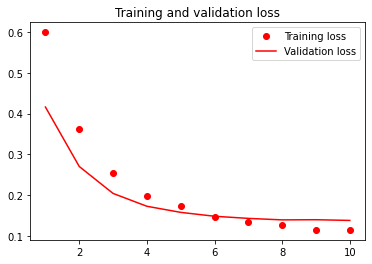

In [326]:
loss = history.history['loss'] 
epochs_list = range(1, len(loss) + 1) 
plt.figure()
loss = history.history['loss'] 
val_loss = history.history['val_loss']
# round_error = history.history['round_error']
# val_round_error = history.history['val_round_error']

plt.plot(epochs_list, loss, 'ro', label='Training loss') 
plt.plot(epochs_list, val_loss, 'r-', label='Validation loss')
# plt.plot(epochs_list, round_error, 'bo', label='round error')
# plt.plot(epochs_list, val_round_error, 'b-', label='Validation round error')
plt.title('Training and validation loss')
plt.legend()

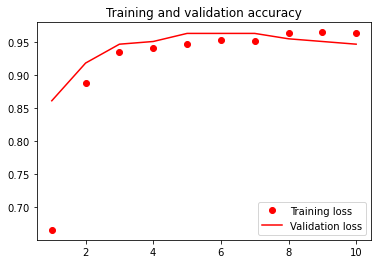

In [327]:
plt.figure()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs_list, accuracy, 'ro', label='Training loss') 
plt.plot(epochs_list, val_accuracy, 'r-', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend()

In [94]:
material_classifier.save(f'../models/materials_metric/Epo{epochs}_D{data_dim}D{significantly_dim}DrO{drop_out}')

NameError: name 'material_classifiermodel' is not defined

In [95]:
f'../models/materials_metric/Epo{epochs}_D{data_dim}D{significantly_dim}DrO{drop_out}'

'../models/materials_metric/Epo10_D50D10DrO0.2'

In [288]:
import keras
material_classifier = keras.models.load_model('../models/materials_metric/Epo10_D50D10DrO0.2')

In [328]:
score = material_classifier.evaluate(data_test, labels_test)

4/4 [==============================] - 0s 1ms/step - loss: 0.1124 - accuracy: 0.9597


In [329]:
material_classifier.predict(np.array([word2vec('amethyst')]))[0, 0]

0.7941816

In [226]:
import nltk, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.parsing.preprocessing import remove_stopwords

def remove_stops(sentence):
    sentence = remove_stopwords(sentence)
    sentence = re.sub(r'\|\|\|', r' ', sentence)
    sentence = re.sub(r'[^\w]', r' ', sentence)
    sentence = re.sub(r'[0-9]+', r' ', sentence)
    return re.sub(r'http\S+', r' ', sentence)

lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    return ' '.join([lemmatizer.lemmatize(word, wordnet.NOUN)
                     for word in nltk.word_tokenize(sentence)])

In [227]:
patent_df = pd.read_csv('../res/abstracts.csv')
words2vectors = dict()
for text in patent_df['abstract'].values:
    text = remove_stops(text)
    text = lemmatize(text)
    words = nltk.word_tokenize(text)
    for word in words:
        word = word.lower()
        if word in words2vectors.keys():
            continue
        words2vectors[word] = word2vec(word)

In [28]:
def psd_neural_metric(words2vec):
    return 1 - material_classifier.predict(np.array(words2vec))[:, 0]

In [29]:
psd_neural_metric([word2vec('tin'), word2vec('dog')])

array([0.05120611, 0.9993044 ], dtype=float32)

In [30]:
window = 1000
neural_thematicy_words = []
size = len(words2vectors.keys())
j = 0
words = []
wordsvecs = []
for i, word in enumerate(words2vectors.keys()):
    if j < 1000:
        w2v = words2vectors[word]
        if w2v is not None:
            words.append(word)
            wordsvecs.append(w2v)
            j += 1
        continue
    thematicies = psd_neural_metric(np.array(wordsvecs))
    for word, thematicy in zip(words, thematicies):
        if thematicy < 0.3:
            neural_thematicy_words.append((word, thematicy))
    j = 0
    words = []
    wordsvecs = []
    print(f'\r{1. * i / size}', end='')

0.995309605980252474

In [31]:
sorted_neural_thematicy_words = np.array(sorted(neural_thematicy_words, key=lambda x: x[1]))
new_thematicy_words = sorted_neural_thematicy_words[sorted_neural_thematicy_words[:,1].astype(float) < 0.025]

In [32]:
len((sorted_neural_thematicy_words))

1299

In [43]:
new_thematicy_words = sorted_neural_thematicy_words[sorted_neural_thematicy_words[:,1].astype(float) < 0.025]

Исследование с помощью t-SNE

In [68]:
from sklearn.manifold import TSNE

In [331]:
data = []
labels = []
for thematic_word in thematic_words:
    if thematic_word in _word2vec:
        data.append(word2vec(thematic_word))
        labels.append('r')
    
for casual_word in casual_words:
    if casual_word in _word2vec:
        data.append(word2vec(casual_word))
        labels.append('b')

c = list(zip(data, labels))
random.shuffle(c)

data, labels = zip(*c)
        
data = np.array(data)

In [332]:
mat_words_significantly_layers = material_significantly_coords.predict(data)

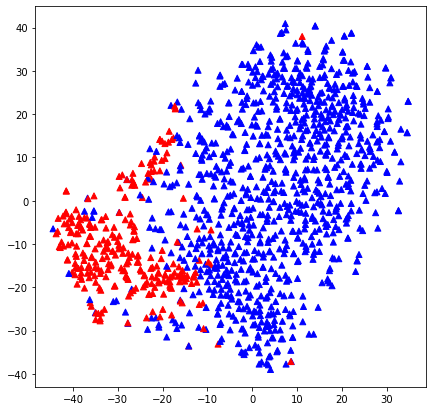

In [333]:
words_significantly_layers_3D = TSNE(n_components=2).fit_transform(data)
fig = plt.figure(figsize = (7, 7))
plt.scatter(words_significantly_layers_3D[:, 0], words_significantly_layers_3D[:, 1], color=labels, marker ='^')

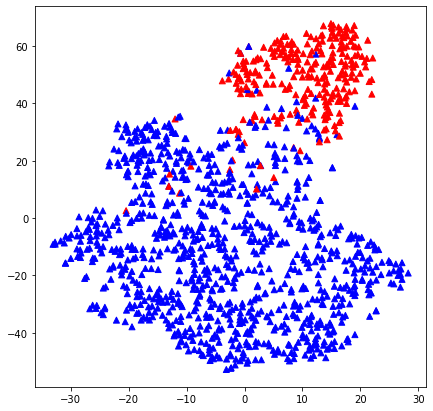

In [334]:
mat_data = TSNE(n_components=2).fit_transform(mat_words_significantly_layers)
fig = plt.figure(figsize = (7, 7))
# ax = plt.axes(projection ="3d")
plt.scatter(mat_data[:, 0], mat_data[:, 1], color=labels, marker ='^')

### Физические эффекты

In [143]:
with open('physical_effects.json') as f:
    pe_thematic_words = json.load(f)
len(pe_thematic_words)

231

In [196]:
data = []
labels = []
for thematic_word in pe_thematic_words:
    if thematic_word in _word2vec:
        data.append(word2vec(thematic_word))
        labels.append(np.array(1))
    
for casual_word in new_casual_words:
    if casual_word in _word2vec:
        data.append(word2vec(casual_word))
        labels.append(np.array(0))

c = list(zip(data, labels))
random.shuffle(c)

data, labels = zip(*c)

    
data = np.array(data)
labels = np.array(labels)

In [197]:
data.shape

(1208, 50)

In [198]:
train_size = int(len(data) * 0.7)
validation_size = int(len(data) * 0.2)
test_size = len(data) - train_size - validation_size

data_train         = data[:train_size]
labels_train       = labels[:train_size]
data_validation    = data[train_size:train_size+validation_size]
labels_validation  = labels[train_size:train_size+validation_size]
data_test          = data[train_size+validation_size:]
labels_test        = labels[train_size+validation_size:]

In [240]:
data_dim = 50
significantly_dim = 10
drop_out = 0.2
output_dim = 1

input_layer = layers.Input(shape=(data_dim,))
significantly_layer = layers.Dense(significantly_dim, activation='sigmoid')(input_layer)
significantly_layer_dropout = layers.Dropout(drop_out)(significantly_layer)
output_layer = layers.Dense(output_dim, activation=tf.keras.activations.sigmoid)(significantly_layer_dropout)


pe_classifier = Model(input_layer, output_layer)
pe_significantly_coords = Model(input_layer, significantly_layer)

optimizer = keras.optimizers.Adam()
pe_classifier.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

batch_size = 8
epochs=7
history = pe_classifier.fit(
    data_train, labels_train,
    epochs=epochs, 
    batch_size=batch_size,
    shuffle=True,
    validation_data=(data_validation, labels_validation)
)

Epoch 1/7
106/106 [==============================] - 1s 3ms/step - loss: 0.8382 - accuracy: 0.3786 - val_loss: 0.5715 - val_accuracy: 0.7884
Epoch 2/7
106/106 [==============================] - 0s 1ms/step - loss: 0.5276 - accuracy: 0.7780 - val_loss: 0.3864 - val_accuracy: 0.9585
Epoch 3/7
106/106 [==============================] - 0s 1ms/step - loss: 0.3943 - accuracy: 0.8636 - val_loss: 0.2865 - val_accuracy: 0.9834
Epoch 4/7
106/106 [==============================] - 0s 1ms/step - loss: 0.3071 - accuracy: 0.9239 - val_loss: 0.2272 - val_accuracy: 0.9917
Epoch 5/7
106/106 [==============================] - 0s 1ms/step - loss: 0.2629 - accuracy: 0.9406 - val_loss: 0.1885 - val_accuracy: 0.9959
Epoch 6/7
106/106 [==============================] - 0s 1ms/step - loss: 0.2214 - accuracy: 0.9461 - val_loss: 0.1606 - val_accuracy: 0.9959
Epoch 7/7
106/106 [==============================] - 0s 1ms/step - loss: 0.1857 - accuracy: 0.9665 - val_loss: 0.1401 - val_accuracy: 0.9959


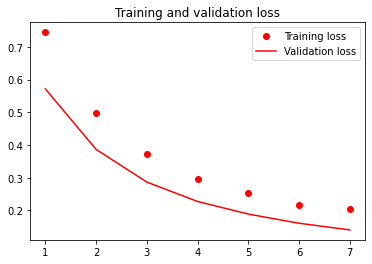

In [241]:
loss = history.history['loss'] 
epochs_list = range(1, len(loss) + 1) 
plt.figure()
loss = history.history['loss'] 
val_loss = history.history['val_loss']
# round_error = history.history['round_error']
# val_round_error = history.history['val_round_error']

plt.plot(epochs_list, loss, 'ro', label='Training loss') 
plt.plot(epochs_list, val_loss, 'r-', label='Validation loss')
# plt.plot(epochs_list, round_error, 'bo', label='round error')
# plt.plot(epochs_list, val_round_error, 'b-', label='Validation round error')
plt.title('Training and validation loss')
plt.legend()

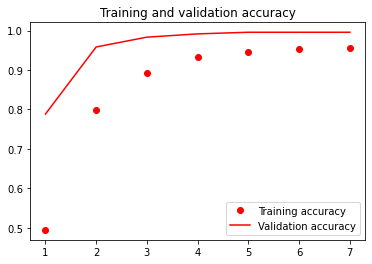

In [242]:
plt.figure()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs_list, accuracy, 'ro', label='Training accuracy') 
plt.plot(epochs_list, val_accuracy, 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

In [244]:
pe_classifier.save(f'../models/physical_effects_metric/Epo{epochs}_D{data_dim}D{significantly_dim}DrO{drop_out}')

In [243]:
pe_classifier.evaluate(data_test, labels_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.1509 - accuracy: 0.9754


[0.15088072419166565, 0.9754098653793335]

In [149]:
import requests

word_site = "https://www.mit.edu/~ecprice/wordlist.10000"

response = requests.get(word_site)
WORDS = response.content.splitlines()

len(WORDS)

10000

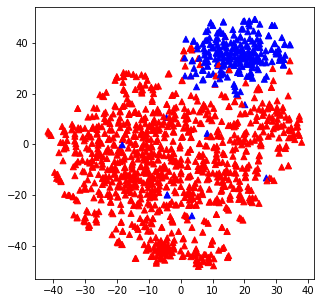

In [247]:
data_3D = TSNE(n_components=2).fit_transform(data)
fig = plt.figure(figsize = (5, 5))
# ax = plt.axes(projection ="3d")
colors = ['r' if l ==0 else 'b' for l in labels]
plt.scatter(data_3D[:, 0], data_3D[:, 1], color=colors, marker ='^')

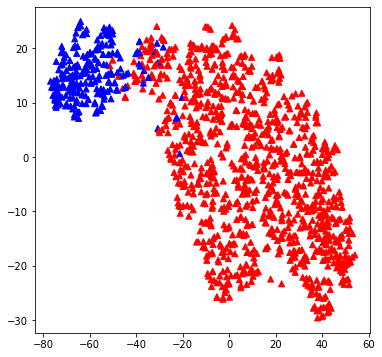

In [248]:
words_significantly_layers = pe_significantly_coords.predict(data)
words_significantly_layers_3D = TSNE(n_components=2).fit_transform(words_significantly_layers)
fig = plt.figure(figsize = (6, 6))
# ax = plt.axes(projection ="3d")
plt.scatter(words_significantly_layers_3D[:, 0], words_significantly_layers_3D[:, 1], color=colors, marker ='^')

In [216]:
len(pe_thematic_words), len(mat_thematic_words), len(new_casual_words)

(231, 275, 1000)

In [339]:
words = []
colors = []
for i, w in enumerate(pe_thematic_words+mat_thematic_words+new_casual_words):
    if w in _word2vec:
        words.append(word2vec(w))
        if i < 231:
            colors.append('r')
        elif i < 231 + 275:
            colors.append('b')
        else:
            colors.append('g')
words = np.array(words)

In [342]:
mat_of_words = material_significantly_coords.predict(words)
pe_of_words = pe_significantly_coords.predict(words)
embedding = np.concatenate((mat_of_words, pe_of_words), axis=1)


In [343]:
embedding_3D = TSNE(n_components=3).fit_transform(embedding)

<IPython.core.display.Javascript object>


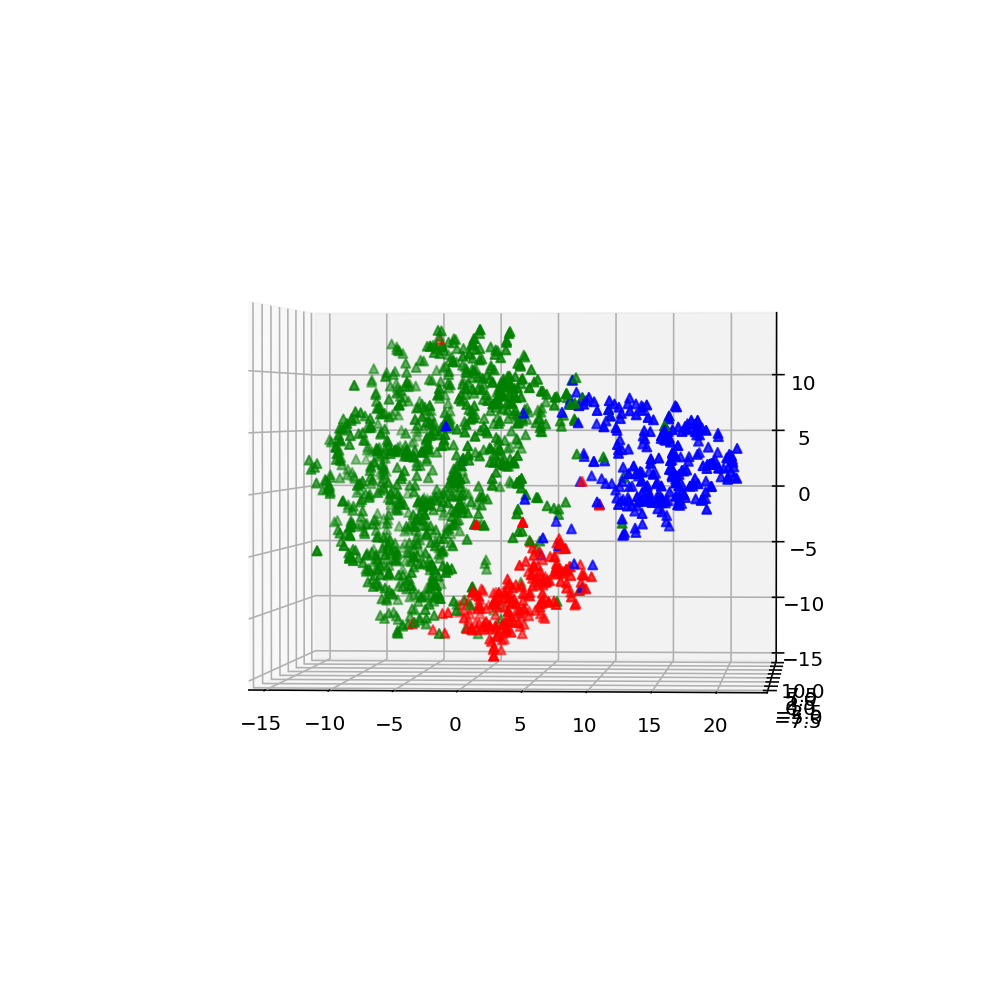

In [344]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
ax.scatter(embedding_3D[:, 0], embedding_3D[:, 1], embedding_3D[:, 2], color=colors, marker ='^')

In [228]:
def psd_neural_metric(words2vec):
    return 1 - pe_classifier.predict(np.array(words2vec))[:, 0]

In [235]:
len(words2vectors.keys())

75047

In [229]:
window = 1000
neural_thematicy_words = []
size = len(words2vectors.keys())
j = 0
words = []
wordsvecs = []
for i, word in enumerate(words2vectors.keys()):
    if j < 1000:
        w2v = words2vectors[word]
        if w2v is not None:
            words.append(word)
            wordsvecs.append(w2v)
            j += 1
        continue
    thematicies = psd_neural_metric(np.array(wordsvecs))
    for word, thematicy in zip(words, thematicies):
        if thematicy < 0.3:
            neural_thematicy_words.append((word, thematicy))
    j = 0
    words = []
    wordsvecs = []
    print(f'\r{1. * i / size}', end='')

0.995309605980252474

In [232]:
sorted_neural_thematicy_words = np.array(sorted(neural_thematicy_words, key=lambda x: x[1]))
new_thematicy_words = sorted_neural_thematicy_words[sorted_neural_thematicy_words[:,1].astype(float) < 0.1]

In [233]:
new_thematicy_words

array([], shape=(0, 2), dtype='<U32')

In [239]:
sorted_neural_thematicy_words[:100, :]

array([['spectroscopy', '0.16031206'],
       ['diffraction', '0.16057432'],
       ['inelastic', '0.16093051'],
       ['ionization', '0.16104448'],
       ['relativistic', '0.1623621'],
       ['gravitational', '0.16247702'],
       ['nmr', '0.16252542'],
       ['diffracted', '0.1627338'],
       ['equipotential', '0.16289568'],
       ['fluorescence', '0.16341579'],
       ['interferometer', '0.16413105'],
       ['osmotic', '0.16416728'],
       ['transcranial', '0.16454566'],
       ['electromagnetic', '0.16470724'],
       ['ionosphere', '0.16512454'],
       ['anisotropy', '0.1653285'],
       ['subtended', '0.1655246'],
       ['radiofrequency', '0.16563487'],
       ['turbidity', '0.16566676'],
       ['phonon', '0.16567999'],
       ['calorimeter', '0.16568303'],
       ['excitation', '0.16585195'],
       ['microscopy', '0.16587979'],
       ['electrochemical', '0.16592848'],
       ['adsorption', '0.16610396'],
       ['exothermic', '0.1662234'],
       ['attenuation', '0.